# Credit Card Default Prediction Project

Based on the dataset UCI Machine Learning Repository

The original paper that works with this dataset is : Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

* __[Link to original paper](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf)__

* __[Link to UCI dataset page](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)__

### Dataset Description
* Data consists of 30 000 points and 23 features and 1 label


### Project Outline
Data preparation and exploration -> ML models hyperparameters tuning -> Combination into a final model

## Import : Data and Libraries
### Library Imports

In [24]:
# Imports
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics, preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from EvalModel_helper import fit_Model, EvalMetrics

sns.set_style("dark")
sns.set_context("paper")

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


### Import and pre-processing of dataset 
(preprocessing : transforming data into ML model readable format)

In [25]:
# data imports

### EDIT FILEPATH IF NECESSARY
root = '.'
data_dir = '/DataFiles/'

# form filepaths
data_path = root + data_dir
train_file = data_path + 'CreditCard_train.csv'
test_file = data_path + 'CreditCard_test.csv'

# load
_df_train = pd.read_csv(train_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
_df_test = pd.read_csv(test_file, index_col=0, header=1).rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})

# create copy df for handling
df_train = _df_train.copy()
df_test = _df_test.copy()

### Data Checking

In [26]:
df_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
count,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,-0.252917,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,1.136993,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


In [27]:
features = list(df_train.columns)[:-1]

# renaming columns for consistency and simplicity
df_train = df_train.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
df_test = df_test.rename(columns={'PAY_0':'PAY_1', 'default payment next month':'DEFAULT'})
label = df_train.columns[-1]

y_train = df_train[label]
X_train = df_train[features]

y_test = df_test[label]
X_test = df_test[features]


__Comment__ : All the data types are integers and thus workable for ML models. There are no null values (arbitrarily checked and all features have the same count). Values in the `SEX`, `EDUCATION` <br>
Optional to check and explore the data further into .DataExploration.

## Data Pipeline
* includes scaling, sampling and (future work : feature transformation)

We take the training:validation:test ratios as 60:20:20.
We change X_train into a a training set and validation set.

In [28]:
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state = 0)


Scaling the dataset for computational efficiency of ML models operations (fitting, prediction).

In [29]:
from imblearn.over_sampling import SMOTE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# X_train_transformed, y_train_transformed = SMOTE(random_state=3).fit_resample(X=X_train, y=y_train)



### Benchmarking some standard ML models

Checking the ML models
* xgboost, adaboost, gradientboostingregressor, logistic regression and support vector machines


## Hyperparameter tuning of ML models

Saving data in a pickle file and opened again in model objectives. (not sure if I can include them as input to the objectives of each model, for version 2..)

In [30]:
import pickle

with open('objs.pkl', 'wb') as f:
    pickle.dump([X_train, y_train, X_validation, y_validation], f)
f.close()

Hyperparameter tuning framework consists of a tuner (hyperopt), optimization space (model dependent), and objective function (model  dependent)
These are imported.

### ML models to be optimized


In [31]:
# Optimizer
from hyperopt import Trials, fmin, tpe

# Model hyperparameter space to be optimized
from Models_spaces import space_xgb, space_ada, space_gbrt, space_log, space_svm

# Model objective function
from Models_objectives import objective_xgb, objective_ada, objective_gbrt, objective_log, objective_svm



### Tuning

For tuning we will be first split up the training data into a validation


long_run functionality, to check the script we can have the variable `short_run=True`

In [32]:
long_run = True

if long_run:
    max_evals = 50
    max_evals_gbrt = 7
if not long_run:
    max_evals = 1
    max_evals_gbrt = 1


In [33]:
trials = Trials()

best_hyperparams = fmin(fn = objective_xgb,
                        space = space_xgb,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)


print("The best hyperparameters are : ","\n")
print(best_hyperparams)



SCORE:                                                
0.8048333333333333                                    
SCORE:                                                                           
0.8035                                                                           
SCORE:                                                                           
0.8043333333333333                                                               
SCORE:                                                                           
0.8058333333333333                                                               
SCORE:                                                                           
0.8046666666666666                                                               
SCORE:                                                                           
0.8048333333333333                                                               
SCORE:                                                                

[14:01:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Performance on fitting data of model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9267151796260045,
             gamma=1.01854676464289, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=18, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=61.0,
             reg_lambda=0.583387, scale_pos_weight=1, silent=False,
             subsample=0.8, tree_method='exact', validat

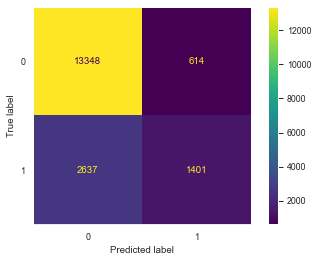

In [34]:
# still to be changed to similar to following models
xgb_reg = xgb.XGBRegressor(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=best_hyperparams['learning_rate'],
                      colsample_bytree = best_hyperparams['colsample_bytree'],
                      min_child_weight = best_hyperparams['min_child_weight'],
                      reg_lambda = best_hyperparams['reg_lambda'],
                      objective='reg:squarederror',
                      n_estimators=180, 
                      reg_alpha = best_hyperparams['reg_alpha'],
                      max_depth=best_hyperparams['max_depth'],
                      gamma=best_hyperparams['gamma'])

xgb_reg = fit_Model(xgb_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)

In [35]:

from sklearn.metrics import accuracy_score
trials = Trials()

best_hyperparams = fmin(fn = objective_gbrt,
                        space = space_gbrt,
                        algo = tpe.suggest,
                        max_evals = max_evals_gbrt,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)



SCORE:                                               
0.78                                                 
SCORE:                                                            
0.8075                                                            
SCORE:                                                              
0.8148333333333333                                                  
SCORE:                                                                          
0.7538333333333334                                                              
SCORE:                                                                          
0.8156666666666667                                                              
SCORE:                                                                          
0.2615                                                                          
SCORE:                                                                          
0.7908333333333334                                   

Performance on fitting data of model GradientBoostingRegressor(learning_rate=0.057307643973049466, max_depth=5.0) 

Accuracy score: 0.8385
Recall score: 0.4006934125804854
Precision_score: 0.768646080760095
ROC/AUC score: 0.6829065114757462
F1 score: 0.5267784470128603


Confusion Matrix on the fitting data


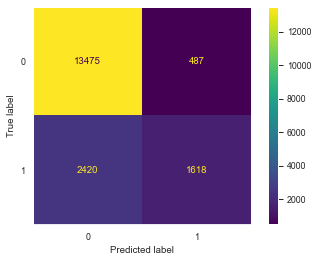

In [36]:
gbrt_loss_functions = ['ls', 'lad', 'huber', 'quantile']

gbrt_reg = GradientBoostingRegressor(
        max_depth = best_hyperparams['max_depth'],
        learning_rate=best_hyperparams['learning_rate'],
        loss = gbrt_loss_functions[best_hyperparams['loss']])

gbrt_reg = fit_Model(gbrt_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)

In [37]:

trials = Trials()

best_hyperparams = fmin(fn = objective_ada,
                        space = space_ada,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


SCORE:                                                
0.8148333333333333                                    
SCORE:                                                                           
0.816                                                                            
SCORE:                                                                           
0.8158333333333333                                                  
SCORE:                                                              
0.8178333333333333                                                  
SCORE:                                                                           
0.8175                                                                           
SCORE:                                                                           
0.8151666666666667                                                               
SCORE:                                                                           
0.817                      

Performance on fitting data of model AdaBoostRegressor(learning_rate=0.04591829175329593, loss='exponential') 

Accuracy score: 0.8202777777777778
Recall score: 0.3630510153541357
Precision_score: 0.688586190699859
ROC/AUC score: 0.6577824909172914
F1 score: 0.475433760337279


Confusion Matrix on the fitting data


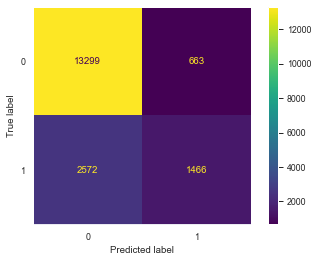

In [38]:
ada_loss_functions = ['linear', 'square', 'exponential']

ada_reg = AdaBoostRegressor(loss = ada_loss_functions[best_hyperparams['loss']], # this value referenced is the index of space_ada with key 'loss'
        learning_rate=best_hyperparams['learning_rate'])

ada_reg = fit_Model(ada_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)



In [39]:
trials = Trials()

best_hyperparams = fmin(fn = objective_log,
                        space = space_log,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)


SCORE:                                                
0.8096666666666666                                    
SCORE:                                                                           
0.8096666666666666                                                               
SCORE:                                                                           
0.8096666666666666                                                               
SCORE:                                                                           
0.8095                                                                           
SCORE:                                                                           
0.8098333333333333                                                                
SCORE:                                                                            
0.8091666666666667                                                                
SCORE:                                                             

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "

/Users/Jurren/Library/Python/3.8/lib/python/site-packages/sklearn/li

Performance on fitting data of model LogisticRegression(C=0.11764152908873718, penalty='l1', solver='liblinear') 

Accuracy score: 0.8081111111111111
Recall score: 0.24170381376919267
Precision_score: 0.7134502923976608
ROC/AUC score: 0.606813803461018
F1 score: 0.3610802811690714


Confusion Matrix on the fitting data


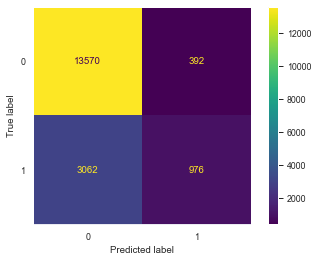

In [40]:
log_penalties = ['l1', 'l2', 'elasticnet']
log_solvers = ['liblinear', 'saga']

log_reg = LogisticRegression(C=best_hyperparams['C'],
                            penalty=log_penalties[best_hyperparams['penalty']],
                            solver=log_solvers[best_hyperparams['solver']])

log_reg = fit_Model(log_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)

In [41]:
trials = Trials()

best_hyperparams = fmin(fn = objective_svm,
                        space = space_svm,
                        algo = tpe.suggest,
                        max_evals = max_evals,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:                                                
0.8025                                                
SCORE:                                                               
0.8145                                                               
SCORE:                                                               
0.8113333333333334                                                   
SCORE:                                                               
0.79                                                                 
SCORE:                                                               
0.7946666666666666                                                   
SCORE:                                                               
0.815                                                                
SCORE:                                                               
0.815                                                               
SCORE:                                             

Performance on fitting data of model SVC(C=0.6959354436457543) 

Accuracy score: 0.8221666666666667
Recall score: 0.35190688459633485
Precision_score: 0.7087281795511222
ROC/AUC score: 0.6550395331161019
F1 score: 0.47029621049147774


Confusion Matrix on the fitting data


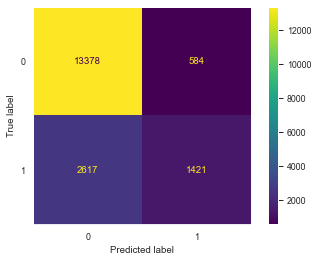

In [42]:
svm_kernel = ['poly', 'rbf']
svm_degree = ['2','3','4']

if best_hyperparams =='poly':
    svm_reg = SVC(C=0.6959354436457543,
              kernel=svm_kernel[best_hyperparams['kernel']],
                  degree = svm_degree[best_hyperparams['degree']]
               )
else: 
    svm_reg = SVC(C=0.6959354436457543,
              kernel=svm_kernel[best_hyperparams['kernel']])

svm_reg = fit_Model(svm_reg, X_train, y_train,eval_metrics=True, confusion_matrix=True)




The search selects the best considered (not the best in the space) generalizable hyperparameters (i.e. the ones that perform best, after fitting on the training set and prediction on the validation set).
In this limited analysis, these hyperparameters are considered the best generalizable.
Alternatively, we can say that we select these parameters to be tested.
We may find that some ML models allow for a large fluctuation in performance on the validation set, which may indicate that we have 'overfitted' the validation set. This will show on the test set.
We can decide to further train on the validation set, however, it is interesting to see how the performance of the model changes whether we use the validation set or not.

The models are:
`xgb_reg`, `ada_reg`, `gbrt_reg`, `log_reg`, and `svm_reg`

Now we can test these models on the test set. Followed by checking each prediction's 'strenght' by using the Smooth Sorting Method as proposed in the original paper by Yeh and Lien.


### Testing these models


In [43]:
from EvalModel_helper import EvalMetrics

Performance on test data of model XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9267151796260045,
             gamma=1.01854676464289, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=18, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=180, n_jobs=8,
             num_parallel_tree=1, random_state=0, reg_alpha=61.0,
             reg_lambda=0.583387, scale_pos_weight=1, silent=False,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None) 

Accuracy score: 0.832
Recall score: 0.334913112164297
Precision_score: 0.7186440677966102
ROC/AUC score: 0.6499238142148059
F1 score: 0.4568965517241379


Confusion Matrix with the true and predicted data
Performance on test data of model AdaBoostRegressor(learning_rate=0.04591829175329593, loss='exponential') 

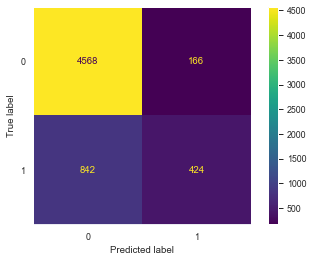

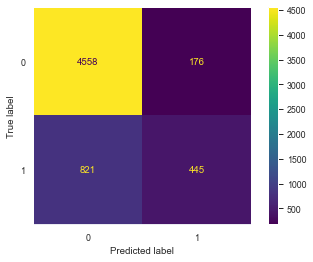

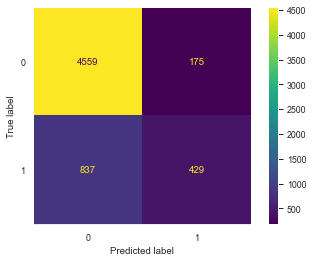

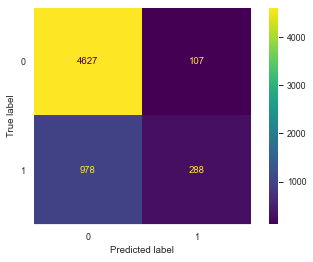

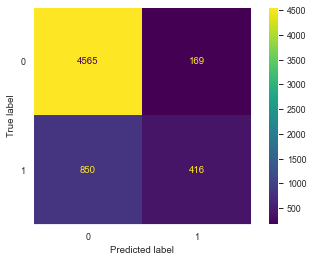

In [44]:
models = [xgb_reg, ada_reg, gbrt_reg, log_reg, svm_reg]
for model in models:
    y_predicted = model.predict(X_test)>0.5
    print(f'Performance on test data of model {model} \n')
    EvalMetrics(y_test, y_predicted, confusion_matrix = True)

We find that these


## Performance at given percentages
### robustness

As opposed to simply classifiying clients as expected to default vs not-expected to default, quantifying is more meaningful. I.e. defining a probability of default has more potential.

To estimate the real probability, the Smooth Sorting Method can be used, which estimates the real probability by looking at neighboring points and taking the mean of these values.

__Smooth Sorting Method__ from the original paper (Yeh, I. C., & Lien, C. H. (2009)): 

$$\text{P}_i = \frac{\sum_{j=-n}^{n}\text{Y}_{i-j}}{2n+1}$$

where $\text{P}_i$ is the estimated real probability of default, $\text{Y}_{i}$ is the binary variable of default (1) or non-default (0), $n$ is the number of data for smoothing.<br>
The Smooth Sorting Method is used on sorted data, from the lowest probability of default occuring to the highest probability of default occuring. 

This is interesting to look at because loaners adopt different risk strategies.    
( (?) for this we consider at 20% and 80% (?) )

we have the lists : `y_predicted` and `y_test`

In [45]:
y_predicted

array([ True, False, False, ...,  True, False, False])

In [47]:
sorted_index = np.argsort(y_predicted)

y_test = y_test[sorted_index]

KeyError: "None of [Int64Index([2999, 3917, 3916, 3914, 3912, 3911, 3909, 3908, 3907, 3918,\n            ...\n             767,  765, 5138,  759,  758, 5149, 5150, 5151, 5127,    0],\n           dtype='int64', name='ID', length=6000)] are in the [index]"

In [ ]:
y_test

In [ ]:
y_avg = []
n = 50
for counter in range(n,len(y_test_sorted)-n):
    intermediate_val = np.mean(y_test_sorted[counter-n:counter+n])
    y_avg.append(intermediate_val)
    
y_predicted_sorted = sorted(y_predicted[n:len(y_predicted)-n])

In [ ]:
plt.plot(y_avg)
plt.show()

In [ ]:
plt.plot(sorted(y_predicted[n:len(y_predicted)-n]),y_avg)
plt.grid(True)
plt.ylim([0,1])
plt.show()

In [ ]:
np.shape(y_predicted[n:len(y_predicted)-n])

In [ ]:
sorted(y_predicted)

In [ ]:
n

In [ ]:
y_predicted_selected = y_predicted[n:len(y_predicted)-n]

In [ ]:

print(r2_score(y_avg,y_predicted_selected))

In [ ]:
len(y_predicted)-n

